In [6]:
import tools21cm as t2c
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams

import sys
sys.path.append("/home/simon/Documents/Projects/Astrophysics/LOFAR/Tomography/tools21cm-master/src/")
import scipy
import pandas as pd
import numpy as np
def load_binary_data(filename, dtype=np.float32): 
    """ 
    We assume that the data was written 
    with write_binary_data() (little endian). 
    """ 
    f = open(filename, "rb") 
    data = f.read() 
    f.close() 
    _data = np.fromstring(data, dtype) 

    return _data

In [23]:
# Creating uv-maps (visibility maps of a given interferometer)

z =[8]

boxsize = 150 #physical dimension
ncells = 100 #cube dimension (number of pixel/voxel per side)
total_int_time = 6. # number of hours of observations per day (6 is assuming we only observe during the night)
for i in range(len(z)):
    uv_map, N_ant  = t2c.get_uv_map(ncells, z[i], total_int_time=total_int_time, boxsize=boxsize) #this automatically assume you want to use SKA1-LOW
    np.savetxt('uv_map_100_150_z%1.6f.txt'%(z[i]),  uv_map, fmt='%d')

512
Making uv map from daily observations.
Completed: 100%

/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


250
62.97164585379818


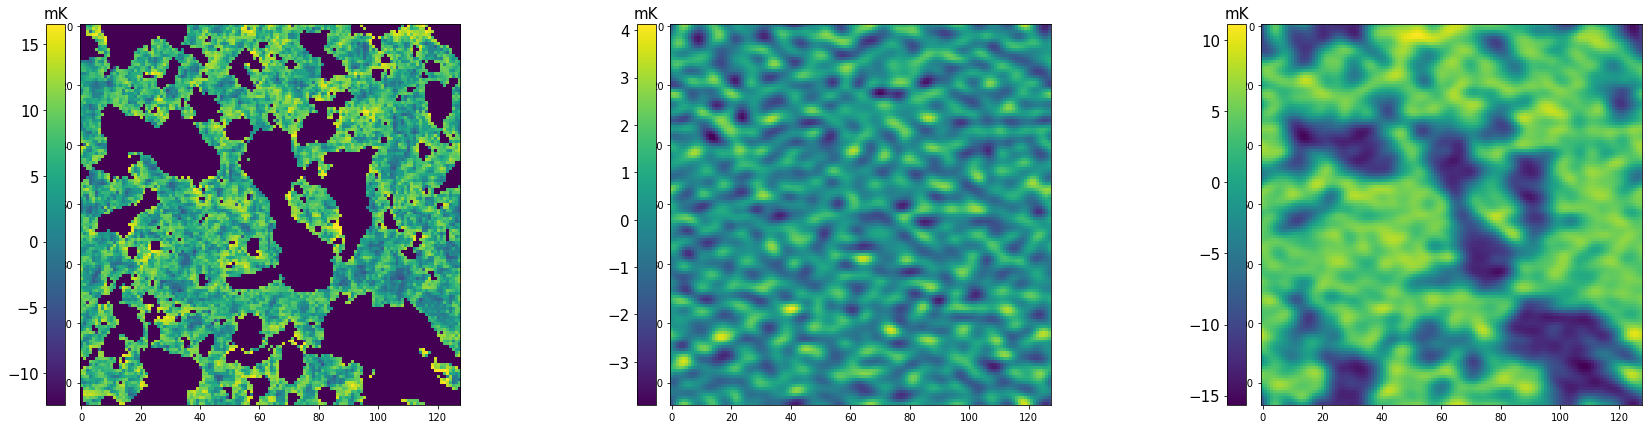

In [25]:
# Creating noise cubes and adding them to co-eval cubes

z =[8]

boxsize = 250. #physical dimension
ncells = 128. #cube dimension (number of pixel/voxel per side)
obs_time = 1000 #assuming e.g 1000 hours of observations
int_time = 10 # Integration time in seconds
total_int_time = 6. # number of hours of observations per day (6 is assuming we only observe during the night)

N_ant = 512 # number of antennas (SKA1-Low = 512 antennas)
for i in range(len(z)):
    data = load_binary_data('Simulations/128_250/30_15_47/delta_T_1.000000_1.000000_z8.000000_128_250Mpc') # reading the cube
    data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data.shape = (int(ncells), int(ncells), int(ncells))   
        
    uv_map = np.loadtxt('Uv_maps_SKA/128/uv_map_z%1.6f.txt'%(z[i]), ndmin=2)# reading uv_map

    #Create the noise_cube
    noise = t2c.noise_cube_coeval(int(ncells), z[i], obs_time=obs_time,  boxsize=int(boxsize),
                                  total_int_time=total_int_time, int_time=int_time, declination=-30., 
                                  uv_map=uv_map, N_ant=512, verbose = False, fft_wrap=False)       
    print np.std(noise)
    
    #Below is to smooth the noise cube. In practice, we can select only the baselines of SKA < 2km to 
    # smooth the noise and makes it a bit better (otherwise we don't see anything)
    # We smooth in the spatial direction with a gaussian kernel, and in frequency with a top hat (this can change later)
    cut_baseline = 2.
    output_dtheta  = (1+z[i])*21e-5/cut_baseline 
    output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z[i]) * ncells/boxsize

    kernel = t2c.gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
    kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
    kernelfft[uv_map == 0] = 0
    uv_map = kernelfft

    data_smo = np.zeros((data.shape))
    noise_smo = np.zeros((data.shape)) # just if you want to plot only the noise at the end
    
    #adding the noise to the observaiton in fourier space
    for ii in range(int(ncells)):
        data_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data[:,:,ii]) \
                                          + np.fft.fft2(noise[:,:,ii]), uv_map/np.max(uv_map))))
        noise_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(noise[:,:,ii]), uv_map/np.max(uv_map))))

    output_data = np.zeros(data_smo.shape)
    output_noise = np.zeros(noise_smo.shape)

    kernel = t2c.tophat_kernel(int(ncells), output_ang_res)
    
    for ii in range(int(ncells)):
        output_data[ii,:,:] = t2c.smooth_with_kernel(data_smo[ii,:,:], kernel)
        output_noise[ii,:,:] = t2c.smooth_with_kernel(noise_smo[ii,:,:], kernel)

 
    img = output_data.astype(float)
    img = img - np.mean(img) #In practice, we move the mean from the observation (interferometry does not have a reference basis)
    
    plt.figure(figsize=(30,7))
    
    ax = plt.subplot(1, 3, 1)
    cs=plt.imshow(data[:,:,50].astype(float)-np.nanmean(data))
    cbar = plt.colorbar(cs, ax=[ax],  fraction=0.046, pad=0.03, location = 'left')
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.set_title(r'mK',size = 15)
    ax = plt.subplot(1, 3, 2)
    cs=plt.imshow(output_noise[:,:,50].astype(float)-np.nanmean(output_noise))
    cbar = plt.colorbar(cs, ax=[ax],  fraction=0.046, pad=0.03, location = 'left')
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.set_title(r'mK',size = 15)
    ax = plt.subplot(1, 3, 3)
    cs=plt.imshow(img[:,:,50].astype(float))   
    cbar = plt.colorbar(cs, ax=[ax],  fraction=0.046, pad=0.03, location = 'left')
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.set_title(r'mK',size = 15)
    plt.show()


In [24]:
#Create the noise_cube
#uv_map = np.loadtxt('Uv_maps_SKA/128/uv_map_z%1.6f.txt'%(z[i]), ndmin=2)# reading uv_map
#uv_map = np.loadtxt('uv', ndmin=2)# reading uv_map

noise = t2c.noise_cube_coeval(100, 8, obs_time=obs_time,  boxsize=150,
                              total_int_time=total_int_time, int_time=int_time, declination=-30., 
                              uv_map=uv_map, N_ant=512, verbose = False, fft_wrap=False)       
print np.std(noise)


150
89.0040327145253


In [38]:
z = float(8)
nuso  = 1420.0/(1.0 + z)
depth_mhz = (t2c.cm.z_to_nu(t2c.cm.cdist_to_z(t2c.cm.z_to_cdist(z)-boxsize/2))-
             t2c.cm.z_to_nu(t2c.cm.cdist_to_z(t2c.cm.z_to_cdist(z)+boxsize/2)))/ncells
delnu = depth_mhz*1e3                                          # in kHz
effective_baseline = np.sum(uv_map)
# Standard definition of sky temperature
T_sky_atnu300MHz= 60.0                                              #K
# Koopmans et al. (2015) definition of sky temperature
# T_sky_atnu300MHz= 68.3  					    #K
T_sky = T_sky_atnu300MHz*(300.0/nuso)**2.55
# Koopmans et al. 
# Receiver temperature
T_rcvr = 40                                                         #K
T_sys  = 1.1*T_sky + T_rcvr
ant_radius_ska  = 35./2. 	                                    #in m
nu_crit = 1.1e5 						    # in kHz
N_ant_ska=512
if nuso>nu_crit: 
    ep = (nu_crit/nuso)**2
else: 
    ep = 1. 	
A_ant_ska = ep*np.pi*ant_radius_ska*ant_radius_ska
sigma     = np.sqrt(2.0)*t2c.KB_SI*(T_sys/A_ant_ska)/np.sqrt((depth_mhz*1e6)*(obs_time*3600.0))/t2c.janskytowatt*1e3/np.sqrt(N_ant_ska*N_ant_ska/2.0) ## in mJy
rms_noi  = 1e6*np.sqrt(2)*t2c.KB_SI*T_sys/A_ant_ska/np.sqrt(depth_mhz*1e6*int_time)/t2c.janskytowatt #in muJy
sigma    = rms_noi/np.sqrt(N_ant_ska*(N_ant_ska-1)/2.0)/np.sqrt(3600*obs_time/int_time)      #in muJy

print('\nExpected: rms in image in muJy per beam for full =', sigma)
print('Effective baseline =', sigma*np.sqrt(N_ant_ska*N_ant_ska/2.0)/np.sqrt(effective_baseline), 'm')
print('Calculated: rms in the visibility =', rms_noi, 'muJy')

('\nExpected: rms in image in muJy per beam for full =', 3.29295679084342)
('Effective baseline =', (43.8824797555794+0j), 'm')
('Calculated: rms in the visibility =', 714607.7390006492, 'muJy')
